[View in Colaboratory](https://colab.research.google.com/github/jyuan0128/developerWorks/blob/master/01_NeuralNetwork_chainer_run.ipynb)

# Chainerによるニューラルネットワーク

##本チュートリアルではchainerを利用してニューラルネットワークの実装を確認，学習および評価を行います．　環境としてはGoogle が提供する Google Colaboratory上でおこないます．

Goolge Colaboratory上にChainerとCupyをインストールします．

In [1]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1379  100  1379    0     0   7747      0 --:--:-- --:--:-- --:--:--  7747
+ apt -y -q install cuda-libraries-dev-9-2
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-npp-dev-9-2
  cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
The following NEW packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-libraries-dev-9-2
  cuda-npp-dev-9-2 cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
0 upgraded, 9 newly installed, 0 to remove and 2 not upgraded.
Need to get 332 MB of archives.
After this operation, 972 MB of additional disk space will be used.
Get:1 https://develop

Chainerでニューラルネットワークを学習するために必要なモジュールや関数をインポートします．

In [0]:
import numpy as np
import chainer
from chainer import Chain, Variable
import chainer.functions as F
import chainer.links as L


chainerのバージョンを確認します．

In [3]:
chainer.__version__

'5.0.0'

次に学習データを読み込みます．MNISTデータセットはチュートリアルでよく利用されるデータセットであり，chainerではMNISTデータセットを取得し，学習するためのフォーマットに変換してくれます．データセットには学習用とテスト用のデータに分かれており，それぞれtrain_dataset, test_datasetとします．また，それらには画像データと教師ラベルがあり，それらをtrain_xとtrain_y，test_xとtest_yとします．

In [4]:
train_dataset, test_dataset = chainer.datasets.get_mnist()
train_x,train_y = train_dataset._datasets
test_x, test_y = test_dataset._datasets

学習データのサイズを確認します．学習データ数は6万枚，１つのデータのサイズは784次元となっています．

In [5]:
print (train_x.shape, train_y.shape)

(60000, 784) (60000,)


MNISTデータセットに含まれる画像を表示してみます．ここでは，matplotlibで複数の画像を表示させるプログラムを利用します．

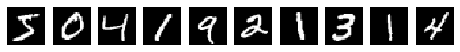

In [6]:
import cv2
import matplotlib.pyplot as plt
import os.path

cols =10

def clearLabel(_ax):
  _ax.tick_params(labelbottom="off",bottom="off")
  _ax.tick_params(labelleft="off",left="off")
  _ax.set_xticklabels([]) 
  _ax.axis('off')
  return _ax

def readImage(idx):
    bimg = train_x[idx].copy()
    label = train_y[idx]
    bimg = bimg.reshape(28,28)
    return bimg

  
fig = plt.figure()

for c in range(cols):
    ax1 = fig.add_subplot(1, cols, c+1)
    clearLabel(ax1)
    show_img1 = readImage(c)
    plt.gray()
    plt.imshow(show_img1)



ニューラルネットワークを定義します．ここでは，入力層，中間層，出力層から構成される３層のニューラルネットワークとします．入力層のユニット数は入力データのサイズによります．ここではNoneとし，データにより変更できるようにしておきます．中間層と出力層のユニット数は引数として与え，それぞれn_units，n_outとします． Chainerでは，\__init\__関数にこれらの引数を与えて各層を定義します．各層はlinear関数としています．これは全結合層を意味しています．そして，\__call\__関数で定義した層を接続して処理するように記述します．\__call\__関数の引数xは入力データです．それを\__init\__関数で定義したl1という中間層に与え，その出力を活性化関数であるrelu関数に与えます．その出力をh1としています．h1は出力層h2に与えられ，その出力をh2としています．

In [0]:
class NN(chainer.Chain):
    def __init__(self, n_units, n_out):
        super().__init__(
            l1=L.Linear(None, n_units),
            l2=L.Linear(n_units, n_out),
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        return self.l2(h1)

中間層と出力層のユニット数を定義します．ここでは中間層のユニット数を50，出力層のユニット数を10とします．

In [0]:
n_units = 50
out_units = 10

各層のユニット数をNN関数の引数として与え，ネットワークモデルを定義します．学習を行う際の最適化方法としてモーメンタムSGD(モーメンタム付き確率的勾配降下法）を利用します．また，学習率を0.01，モーメンタムを0.9として引数に与えます．そして，最適化方法のsetup関数にネットワークモデルを与えます．

In [22]:
model = NN(n_units, out_units)
optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
optimizer.setup(model)

１回の誤差を算出するデータ数（ミニバッチサイズ）を100，学習エポック数を100とします．

In [0]:
batch_size = 100
epoch_num = 10

MNISTの学習データサイズを取得し，１エポック内における更新回数を求めます．学習データは毎エポックでランダムに利用するため，numpyのpermutationという関数を利用します．各更新において，学習用データと教師データをそれぞれxとtとします．学習モデルにxを与えて各クラスの確率yを取得します．各クラスの確率yと教師ラベルtとの誤差をsoftmax coross entropy誤差関数で算出します．また，認識精度も算出します．そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．

In [13]:
train_data_num = train_x.shape[0]
iter_one_epoch = int(train_x.shape[0]/batch_size)
for epoch in range(epoch_num):
        sum_loss = 0
        sum_accuracy = 0
        perm = np.random.permutation(train_data_num)
        for i in range(0, train_data_num, batch_size):
                x = Variable(train_x[perm[i:i+batch_size]])
                t = Variable(train_y[perm[i:i+batch_size]])
                y = model(x)        
                model.zerograds()
                loss = F.softmax_cross_entropy(y, t)
                acc = F.accuracy(y, t)
                loss.backward()
                optimizer.update()
                sum_loss += loss.data*batch_size
                sum_accuracy += acc.data*batch_size
        print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch+1, sum_loss/train_data_num, sum_accuracy/train_data_num))
    
    

epoch: 1, mean loss: 0.49045873696605363, mean accuracy: 0.8664666673541069
epoch: 2, mean loss: 0.269239149056375, mean accuracy: 0.9240500019987424
epoch: 3, mean loss: 0.22060017596930265, mean accuracy: 0.9375166694323221
epoch: 4, mean loss: 0.18639487159748871, mean accuracy: 0.9473000002900759
epoch: 5, mean loss: 0.16118786424398424, mean accuracy: 0.9546500028173128
epoch: 6, mean loss: 0.14379235561316212, mean accuracy: 0.9591333367427191
epoch: 7, mean loss: 0.12958766938187183, mean accuracy: 0.9634833389520645
epoch: 8, mean loss: 0.11875385965841512, mean accuracy: 0.9660000064969063
epoch: 9, mean loss: 0.11014389376156032, mean accuracy: 0.9686000064015389
epoch: 10, mean loss: 0.10281845670193433, mean accuracy: 0.9713666751980782


学習できたネットワークモデルを利用して評価を行います．

In [14]:
cnt = 0
test_data_num = test_x.shape[0]
for i in range(test_data_num):
    x = Variable(np.array([test_x[i]], dtype=np.float32))
    t = test_y[i]
    y = model(x)
    y = np.argmax(y.data[0])
    if t == y:
        cnt += 1
 
print("test accuracy: {}".format(cnt/test_data_num))

test accuracy: 0.9672


## 課題　
###以下の課題に取り組みましょう

1  ネットワーク構造を変えて実験しましょう． 

   まず，中間層のユニット数を200個にしましょう．
   
   次に，中間層を1層増やしましょう．その際， 中間層のユニット数は200個としましょう．

In [15]:
n_units = 200
model = NN(n_units, out_units)
optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
optimizer.setup(model)

train_data_num = train_x.shape[0]
iter_one_epoch = int(train_x.shape[0]/batch_size)
for epoch in range(epoch_num):
        sum_loss = 0
        sum_accuracy = 0
        perm = np.random.permutation(train_data_num)
        for i in range(0, train_data_num, batch_size):
                x = Variable(train_x[perm[i:i+batch_size]])
                t = Variable(train_y[perm[i:i+batch_size]])
                y = model(x)        
                model.zerograds()
                loss = F.softmax_cross_entropy(y, t)
                acc = F.accuracy(y, t)
                loss.backward()
                optimizer.update()
                sum_loss += loss.data*batch_size
                sum_accuracy += acc.data*batch_size
        print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch+1, sum_loss/train_data_num, sum_accuracy/train_data_num))


epoch: 1, mean loss: 0.48499074575801693, mean accuracy: 0.868200001269579
epoch: 2, mean loss: 0.24341461749126514, mean accuracy: 0.9308333347241083
epoch: 3, mean loss: 0.18917635112379988, mean accuracy: 0.9462000015377998
epoch: 4, mean loss: 0.15628758880620203, mean accuracy: 0.9555333350102106
epoch: 5, mean loss: 0.13320058987786373, mean accuracy: 0.9621166703104973
epoch: 6, mean loss: 0.11632369552118083, mean accuracy: 0.9673666723569234
epoch: 7, mean loss: 0.10311739737788836, mean accuracy: 0.9712000072995821
epoch: 8, mean loss: 0.09268048759549856, mean accuracy: 0.974350009461244
epoch: 9, mean loss: 0.08383879527760049, mean accuracy: 0.9762333431839942
epoch: 10, mean loss: 0.07642272892408072, mean accuracy: 0.9785833442211151


In [16]:
cnt = 0
test_data_num = test_x.shape[0]
for i in range(test_data_num):
    x = Variable(np.array([test_x[i]], dtype=np.float32))
    t = test_y[i]
    y = model(x)
    y = np.argmax(y.data[0])
    if t == y:
        cnt += 1
 
print("test accuracy1: {}".format(cnt/test_data_num))

test accuracy1: 0.9726


In [0]:
class NN(chainer.Chain):
    def __init__(self, n_units, n_out):
        super().__init__(
            l1=L.Linear(None, n_units),
            l2=L.Linear(n_units, n_units),
            l3=L.Linear(n_units, n_out),
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        return self.l2(h1)
        h2 = F.relu(self.l2(x))
        return self.l3(h1)

In [18]:
n_units = 200
model = NN(n_units, out_units)
optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
optimizer.setup(model)

train_data_num = train_x.shape[0]
iter_one_epoch = int(train_x.shape[0]/batch_size)
for epoch in range(epoch_num):
        sum_loss = 0
        sum_accuracy = 0
        perm = np.random.permutation(train_data_num)
        for i in range(0, train_data_num, batch_size):
                x = Variable(train_x[perm[i:i+batch_size]])
                t = Variable(train_y[perm[i:i+batch_size]])
                y = model(x)        
                model.zerograds()
                loss = F.softmax_cross_entropy(y, t)
                acc = F.accuracy(y, t)
                loss.backward()
                optimizer.update()
                sum_loss += loss.data*batch_size
                sum_accuracy += acc.data*batch_size
        print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch+1, sum_loss/train_data_num, sum_accuracy/train_data_num))


epoch: 1, mean loss: 0.5676414292057356, mean accuracy: 0.8549666687225302
epoch: 2, mean loss: 0.2643198122580846, mean accuracy: 0.9249000010887781
epoch: 3, mean loss: 0.21042744527260462, mean accuracy: 0.9398833348353703
epoch: 4, mean loss: 0.17328375509629648, mean accuracy: 0.9509166676799456
epoch: 5, mean loss: 0.14818446133906643, mean accuracy: 0.9581833363572756
epoch: 6, mean loss: 0.1282019355800003, mean accuracy: 0.9642500057816505
epoch: 7, mean loss: 0.11404418509143094, mean accuracy: 0.9674000055591265
epoch: 8, mean loss: 0.10190373113689323, mean accuracy: 0.9716000081102053
epoch: 9, mean loss: 0.09226280067116022, mean accuracy: 0.9741500094532967
epoch: 10, mean loss: 0.08402511795982719, mean accuracy: 0.9765000090003013


In [19]:
cnt = 0
test_data_num = test_x.shape[0]
for i in range(test_data_num):
    x = Variable(np.array([test_x[i]], dtype=np.float32))
    t = test_y[i]
    y = model(x)
    y = np.argmax(y.data[0])
    if t == y:
        cnt += 1
 
print("test accuracy2: {}".format(cnt/test_data_num))



test accuracy2: 0.9723


2  最適化の方法をAdamに変えて実験しましょう．


In [10]:

n_units = 200
out_units = 10
batch_size = 100
epoch_num = 10
model = NN(n_units, out_units)
optimizer = chainer.optimizers.Adam(alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-08, eta=1.0, weight_decay_rate=0, amsgrad=False)
optimizer.setup(model)

train_data_num = train_x.shape[0]
iter_one_epoch = int(train_x.shape[0]/batch_size)
for epoch in range(epoch_num):
        sum_loss = 0
        sum_accuracy = 0
        perm = np.random.permutation(train_data_num)
        for i in range(0, train_data_num, batch_size):
                x = Variable(train_x[perm[i:i+batch_size]])
                t = Variable(train_y[perm[i:i+batch_size]])
                y = model(x)        
                model.zerograds()
                loss = F.softmax_cross_entropy(y, t)
                acc = F.accuracy(y, t)
                loss.backward()
                optimizer.update()
                sum_loss += loss.data*batch_size
                sum_accuracy += acc.data*batch_size
        print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch+1, sum_loss/train_data_num, sum_accuracy/train_data_num))


epoch: 1, mean loss: 0.4130255226418376, mean accuracy: 0.8954666676217069
epoch: 2, mean loss: 0.16445619848246376, mean accuracy: 0.9525166709224383
epoch: 3, mean loss: 0.11626727827824652, mean accuracy: 0.966366672317187
epoch: 4, mean loss: 0.08809340780911347, mean accuracy: 0.9739666760961214
epoch: 5, mean loss: 0.06919455116614699, mean accuracy: 0.9796500106652578
epoch: 6, mean loss: 0.05646069781001036, mean accuracy: 0.983733344177405
epoch: 7, mean loss: 0.045421093471813945, mean accuracy: 0.9870500096678734
epoch: 8, mean loss: 0.03715018491571148, mean accuracy: 0.989216675957044
epoch: 9, mean loss: 0.031009849311473468, mean accuracy: 0.9911000076929728
epoch: 10, mean loss: 0.024501739629001047, mean accuracy: 0.9933333393931388


In [26]:
cnt = 0
test_data_num = test_x.shape[0]
for i in range(test_data_num):
    x = Variable(np.array([test_x[i]], dtype=np.float32))
    t = test_y[i]
    y = model(x)
    y = np.argmax(y.data[0])
    if t == y:
        cnt += 1
 
print("test accuracy3: {}".format(cnt/test_data_num))


test accuracy3: 0.9627


3  エポック数やミニバッチサイズを変えて実験しましょう．

  まず，ミニバッチサイズを128にしましょう．
  
  次に，エポック数を50にしましょう．

In [25]:
batch_size =128
train_data_num = train_x.shape[0]
iter_one_epoch = int(train_x.shape[0]/batch_size)
for epoch in range(epoch_num):
        sum_loss = 0
        sum_accuracy = 0
        perm = np.random.permutation(train_data_num)
        for i in range(0, train_data_num, batch_size):
                x = Variable(train_x[perm[i:i+batch_size]])
                t = Variable(train_y[perm[i:i+batch_size]])
                y = model(x)        
                model.zerograds()
                loss = F.softmax_cross_entropy(y, t)
                acc = F.accuracy(y, t)
                loss.backward()
                optimizer.update()
                sum_loss += loss.data*batch_size
                sum_accuracy += acc.data*batch_size
        print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch+1, sum_loss/train_data_num, sum_accuracy/train_data_num))
        

cnt = 0
test_data_num = test_x.shape[0]
for i in range(test_data_num):
    x = Variable(np.array([test_x[i]], dtype=np.float32))
    t = test_y[i]
    y = model(x)
    y = np.argmax(y.data[0])
    if t == y:
        cnt += 1
 
print("test accuracy4: {}".format(cnt/test_data_num))


epoch: 1, mean loss: 0.5425036308606466, mean accuracy: 0.8504944444020589
epoch: 2, mean loss: 0.28444726711908974, mean accuracy: 0.9194111110687256
epoch: 3, mean loss: 0.2371968441963196, mean accuracy: 0.9327611110687256
epoch: 4, mean loss: 0.20714781770706175, mean accuracy: 0.9418666666666666
epoch: 5, mean loss: 0.18480735749403635, mean accuracy: 0.9486611110687256
epoch: 6, mean loss: 0.16717538561820983, mean accuracy: 0.9533944444020589
epoch: 7, mean loss: 0.15233015751043955, mean accuracy: 0.9573611110687256
epoch: 8, mean loss: 0.14040881896813712, mean accuracy: 0.9611166666666666
epoch: 9, mean loss: 0.13036216554641725, mean accuracy: 0.96345
epoch: 10, mean loss: 0.12166366636753083, mean accuracy: 0.9660388889312744
test accuracy4: 0.9627


In [27]:
epoch_num = 50
train_data_num = train_x.shape[0]
iter_one_epoch = int(train_x.shape[0]/batch_size)
for epoch in range(epoch_num):
        sum_loss = 0
        sum_accuracy = 0
        perm = np.random.permutation(train_data_num)
        for i in range(0, train_data_num, batch_size):
                x = Variable(train_x[perm[i:i+batch_size]])
                t = Variable(train_y[perm[i:i+batch_size]])
                y = model(x)        
                model.zerograds()
                loss = F.softmax_cross_entropy(y, t)
                acc = F.accuracy(y, t)
                loss.backward()
                optimizer.update()
                sum_loss += loss.data*batch_size
                sum_accuracy += acc.data*batch_size
        print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch+1, sum_loss/train_data_num, sum_accuracy/train_data_num))
        

cnt = 0
test_data_num = test_x.shape[0]
for i in range(test_data_num):
    x = Variable(np.array([test_x[i]], dtype=np.float32))
    t = test_y[i]
    y = model(x)
    y = np.argmax(y.data[0])
    if t == y:
        cnt += 1
 
print("test accuracy5: {}".format(cnt/test_data_num))

epoch: 1, mean loss: 0.11419536668459575, mean accuracy: 0.9682611110687256
epoch: 2, mean loss: 0.10775599094629287, mean accuracy: 0.970044444402059
epoch: 3, mean loss: 0.10114891945123672, mean accuracy: 0.9716833333333333
epoch: 4, mean loss: 0.09655623219013214, mean accuracy: 0.9735166666666667
epoch: 5, mean loss: 0.09195136585235596, mean accuracy: 0.9747277777353922
epoch: 6, mean loss: 0.08744974750677745, mean accuracy: 0.9763611110687256
epoch: 7, mean loss: 0.0836016128818194, mean accuracy: 0.976894444402059
epoch: 8, mean loss: 0.08022422878344854, mean accuracy: 0.9773277777353923
epoch: 9, mean loss: 0.07671629540125528, mean accuracy: 0.979094444402059
epoch: 10, mean loss: 0.07353582992156346, mean accuracy: 0.9804277777353922
epoch: 11, mean loss: 0.071002072874705, mean accuracy: 0.9810777777353923
epoch: 12, mean loss: 0.06847844299475352, mean accuracy: 0.9816833333333334
epoch: 13, mean loss: 0.0653943745692571, mean accuracy: 0.9824666666666667
epoch: 14, mean

ここまでの考察

*   ネットワーク構造を変えてみると、少し精度が改善された
*   最適化adamにした結果、もうちょっと改善（0.972->0.978）
*   バッチサイズやエポックを変更した結果、悪化（過学習？）
*   パラメータを調整することで、精度が変化する
*   パラメータの調整とネットワークの構造が精度に影響している




##別のコードの書き方

ここまでのコードは学習の流れをわかりやすくするために，エポックまたはミニバッチ毎にfor文で学習を行うようにプログラムを作成しました． chainerでは，trainerとupdaterという繰り返し処理を抽象化するクラスが用意されています．これらを利用した場合は，以下のように書くことができます．

SerialIteratorにより学習および評価データを繰り返し取得することができます．　StarndardUpdaterは， SerialIteratorによって繰り返し取得したデータをoptimizerに渡してmodelをアップデートします． TrainerはこのUpdaterの処理を指定されたエポック回数分行い，学習したモデルをresultに保存できます． Trainerにはさまざなま拡張機能を追加できます．Evaluatorは学習したモデルを評価する機能であり，LogReportは学習時のロスは精度を記憶します．これらの記憶されているログをPlotReportが表示したりグラフとして保存したりします．　学習の実行はtrainerクラスのrun関数により行います．

In [14]:
from chainer import training
from chainer.training import extensions

batch_size = 100
epoch_num = 10

n_units = 50
out_units = 10

model = L.Classifier(NN(n_units, out_units))
optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
optimizer.setup(model)  
  
train_dataset, test_dataset = chainer.datasets.get_mnist()

train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size)
test_iter = chainer.iterators.SerialIterator(test_dataset, batch_size,    repeat=False, shuffle=False)

updater = training.updaters.StandardUpdater( train_iter, optimizer, device=-1)
trainer = training.Trainer(updater, (epoch_num, 'epoch'), out='result')

trainer.extend(extensions.Evaluator(test_iter, model, device=-1))

trainer.extend(extensions.dump_graph('main/loss'))

trainer.extend(extensions.LogReport())

trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],  'epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

trainer.run()


epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.563541    0.294832              0.8513         0.915                     3.13914       
2           0.278634    0.242989              0.921333       0.9306                    6.71502       
3           0.232631    0.204502              0.934083       0.9415                    10.3416       
4           0.197345    0.181211              0.944367       0.9478                    13.9737       
5           0.170985    0.160285              0.951917       0.9532                    17.5979       
6           0.152192    0.148452              0.95695        0.9568                    21.2455       
7           0.137362    0.137972              0.961333       0.9583                    24.8807       
8           0.125364    0.128841              0.964333       0.9621                    28.5546       
9           0.115452    0.123842              0.967133       0.963                  

In [28]:
batch_size = 100
epoch_num = 50

n_units = 200
out_units = 10

model = L.Classifier(NN(n_units, out_units))
optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
optimizer.setup(model)  
  
train_dataset, test_dataset = chainer.datasets.get_mnist()

train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size)
test_iter = chainer.iterators.SerialIterator(test_dataset, batch_size,    repeat=False, shuffle=False)

updater = training.updaters.StandardUpdater( train_iter, optimizer, device=-1)
trainer = training.Trainer(updater, (epoch_num, 'epoch'), out='result')

trainer.extend(extensions.Evaluator(test_iter, model, device=-1))

trainer.extend(extensions.dump_graph('main/loss'))

trainer.extend(extensions.LogReport())

trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],  'epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

trainer.run()


epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.484195    0.273538              0.86805        0.9262                    3.90658       
2           0.245821    0.206022              0.930267       0.942                     8.20671       
3           0.192809    0.167739              0.944983       0.9517                    12.5594       
4           0.159414    0.148014              0.953883       0.9578                    16.968        
5           0.135661    0.132359              0.961          0.9611                    21.3317       
6           0.118311    0.118049              0.967083       0.9663                    25.7479       
7           0.10397     0.108935              0.97115        0.9685                    30.2563       
8           0.0930871   0.102286              0.974033       0.9703                    34.6859       
9           0.0843326   0.0967026             0.976217       0.9729                 